In [454]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
import torchvision
import torchvision.transforms as tr
import matplotlib.pyplot as plt
import scipy as sp
from scipy.integrate import odeint
from scipy.integrate import solve_ivp
import random
import math
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset
import torch.optim as optim
import warnings
from torch.utils.tensorboard import SummaryWriter
from filterpy import kalman

writer = SummaryWriter()
warnings.filterwarnings('ignore')

In [455]:
# Creating the Mechanistic Model
def odes(t, m):
    # X is biomass concentration
    # S is substarte concentration
    # V is volume 
    X, S, V = m
    # Declaring the constants
    k = 1
    
    # If time is lesser than 15
    if t < 15:
        # Flow Rate
        F = 1
        # Substrate Concentration coming in
        s0 = 60
      
    # If time is greater than 15
    else:
        F = 0
        s0 = 0
        

    #Declaring mu or growth rate equation
    mu = (5*S)/(10+S+(S**2)/0.1)
    # Declaring the differential equations
    
    # Change in biomass concentration with time
    dxdt = (mu*X) - X*(F/V)
    # Change in substarte concentration with time
    dsdt = -k*mu*X + (F/V)*(s0 - S)
    # Change in volume with time
    dvdt = F
    
    # Returning the above values to calculate the change at the next iteration or time point
    return [dxdt, dsdt, dvdt]

# Declaring the initial conditions of the model
# (Biomass Conc, Substrate Conc, Volume)
m0 = (5, 5, 10)

# Declaring a time vector
t = np.arange(0.0, 200.0, 0.2)

# Solving the differential equation using the odeint method
sol = odeint(odes, m0, t, tfirst = True)
odes(10, m0)

[-0.028301886792452824, 5.028301886792453, 1]

In [456]:
# Extracting biomass conc, substrate conc and volume from the generated solution by
# transposing the matrix
X = sol.T[0]
S = sol.T[1]
V = sol.T[2]

# Computing the growth rate values
mu_list = []
for s in S:
    mu = 0
    mu = (1*s)/(1+s+(s**2)/1)
    mu_list.append(mu)

# Generating the dataset
mdf = pd.DataFrame()
mdf["Time"] = t
mdf["Biomass Concentration"] = X
mdf["Substrate Concentration"] = S
mdf["Volume"] = V
mdf["mu"] = mu_list
relu = nn.ReLU()
mdf_tensor = relu(torch.tensor(mdf.to_numpy(), dtype = torch.float32))
mdf = pd.DataFrame(mdf_tensor.numpy(), columns = ["Time", "Biomass Concentration", "Substrate Concentration","Volume", "mu"])
mu_list = mdf["mu"]
mdf = mdf.set_index("Time")
mdf

,Biomass Concentration,Substrate Concentration,Volume,mu
Time,,,,
0.000000,5.000000,5.000000,10.000000,0.161290
0.200000,4.987693,5.992699,10.200000,0.139673
0.400000,4.965100,6.957977,10.400000,0.123431
0.600000,4.935479,7.894710,10.600000,0.110848
0.800000,4.900981,8.802722,10.800000,0.100844
...,...,...,...,...
199.000000,40.000000,0.000000,25.000002,0.000000
199.199997,40.000000,0.000000,25.000002,0.000000
199.399994,40.000000,0.000000,25.000002,0.000000


In [457]:
def add_noise_col(df, name, scalar):
    name_std = df[name].std()
    df[name] = df[name] + np.random.normal(0, name_std * scalar, len(df[name]))
    
def add_noise_df(df, scalar):
    out = df.copy(deep=True)
    add_noise_col(out, "Biomass Concentration", scalar)
    add_noise_col(out, "Substrate Concentration", scalar)
    add_noise_col(out, "Volume", scalar)
    return out



In [458]:
kal_time = 0

def fx_wrapper(x, dt):
    global kal_time
    kal_time += dt
    return x + np.array(odes(kal_time,x)) * dt
    
def pred_and_upd(ckf, row):
    measurements = np.array([row["Biomass Concentration"], row["Substrate Concentration"], row["Volume"]])
    ckf.predict()
    ckf.update(measurements.reshape(3,1))
    return ckf.x.flatten()

def add_kalman_filter(df):
    out = df.copy(deep=True)
    ckf = kalman.CubatureKalmanFilter(dim_x = 3, dim_z = 3, dt = 0.2, fx = fx_wrapper, hx= lambda x : x)
    ckf.x = np.array(m0).reshape(3,1)

    ckf.predict()

    # z = np.array([4.98,5.32,9.99]).reshape(3,1)
    # ckf.update(z)    
    kalman_est_values = pd.DataFrame(out.apply(lambda row: pred_and_upd(ckf, row), axis=1).tolist())
    kalman_est_values.columns = ["Kalman Estimate Bio", "Kalman Estimate Substrate", "Kalman Estimate Volume"]
    kalman_est_values.reset_index()
    return out.reset_index().join(kalman_est_values)

        

In [459]:
noisy_mdf = add_noise_df(mdf, 0.20)
noisy_mdf

,Biomass Concentration,Substrate Concentration,Volume,mu,Biomass Concentration Original,Substrate Concentration Original,Volume Original
Time,,,,,,,
0.000000,2.614811,-1.539143,9.446020,0.161290,5.000000,5.000000,10.000000
0.200000,6.423782,11.429241,9.778238,0.139673,4.987693,5.992699,10.200000
0.400000,6.274750,0.396723,11.116575,0.123431,4.965100,6.957977,10.400000
0.600000,11.315196,8.647407,10.494406,0.110848,4.935479,7.894710,10.600000
0.800000,2.087495,14.809263,11.048900,0.100844,4.900981,8.802722,10.800000
...,...,...,...,...,...,...,...
199.000000,40.837052,-4.207168,24.382662,0.000000,40.000000,0.000000,25.000002
199.199997,43.335508,0.985563,25.611631,0.000000,40.000000,0.000000,25.000002
199.399994,41.550333,5.360927,25.399490,0.000000,40.000000,0.000000,25.000002


In [460]:
noisy_kalman_mdf = add_kalman_filter(noisy_mdf).set_index("Time")
noisy_kalman_mdf

,Biomass Concentration,Substrate Concentration,Volume,mu,Biomass Concentration Original,Substrate Concentration Original,Volume Original,Kalman Estimate Bio,Kalman Estimate Substrate,Kalman Estimate Volume
Time,,,,,,,,,,
0.000000,2.614811,-1.539143,9.446020,0.161290,5.000000,5.000000,10.000000,4.905744,6.685600,10.414577
0.200000,6.423782,11.429241,9.778238,0.139673,4.987693,5.992699,10.200000,4.955567,7.880923,10.528701
0.400000,6.274750,0.396723,11.116575,0.123431,4.965100,6.957977,10.400000,5.052913,8.220081,10.894229
0.600000,11.315196,8.647407,10.494406,0.110848,4.935479,7.894710,10.600000,5.528693,9.081064,11.068309
0.800000,2.087495,14.809263,11.048900,0.100844,4.900981,8.802722,10.800000,5.151476,10.472077,11.120527
...,...,...,...,...,...,...,...,...,...,...
199.000000,40.837052,-4.207168,24.382662,0.000000,40.000000,0.000000,25.000002,40.838481,0.130602,25.036209
199.199997,43.335508,0.985563,25.611631,0.000000,40.000000,0.000000,25.000002,41.517892,-0.109119,25.112035
199.399994,41.550333,5.360927,25.399490,0.000000,40.000000,0.000000,25.000002,41.402970,0.260349,25.149914


<Axes: xlabel='Time', ylabel='Volume'>

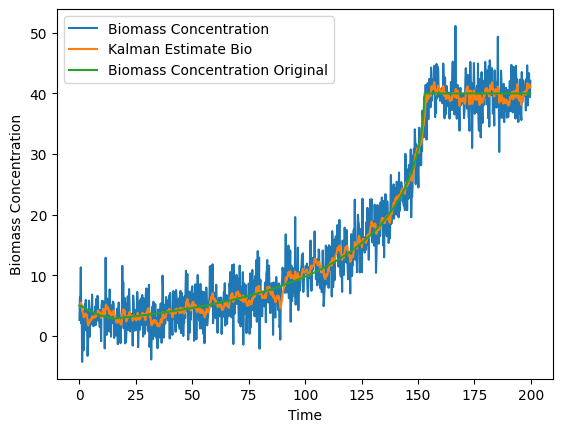

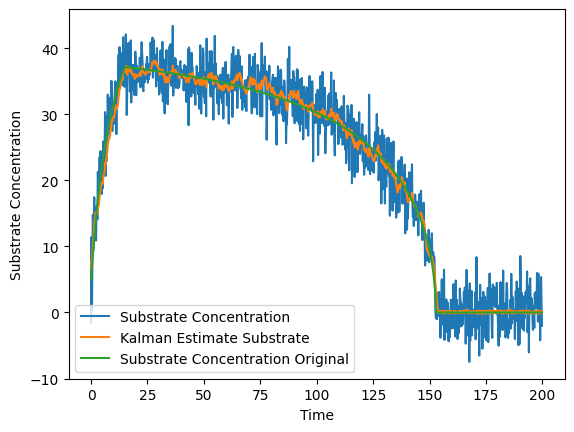

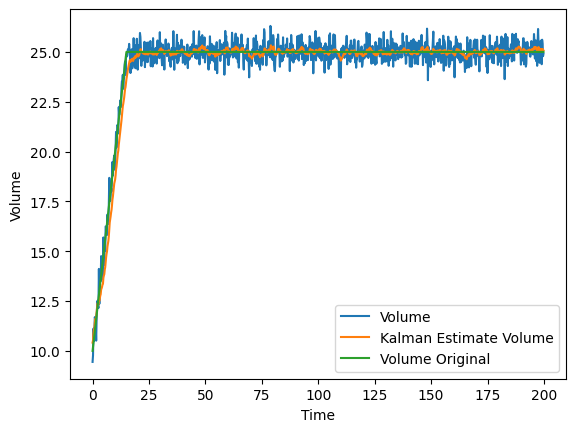

In [461]:
noisy_kalman_mdf[["Biomass Concentration", "Kalman Estimate Bio"]].plot(ylabel = "Biomass Concentration")
noisy_kalman_mdf[["Substrate Concentration", "Kalman Estimate Substrate"]].plot(ylabel = "Substrate Concentration")
noisy_kalman_mdf[["Volume", "Kalman Estimate Volume"]].plot(ylabel = "Volume")



In [462]:
df = pd.DataFrame()
df["Time"] = t
list_b = []
list_s = []
for index in range(len(mdf)):
    if noisy_mdf.iloc[index].at["Biomass Concentration"] > 0:
        list_b.append(np.log(noisy_mdf.iloc[index].at["Biomass Concentration"]))
    else:
        list_b.append(0)
    
    if mdf.iloc[index].at["Substrate Concentration"] > 0:
        list_s.append(np.log(noisy_mdf.iloc[index].at["Substrate Concentration"]))
    else:
        list_s.append(0)
df["Biomass Concentration"] = list_b
df["Substrate Concentration"] = list_s
df["Volume"] = V
df["mu"] = mu_list

In [463]:
df

,Biomass Concentration,Substrate Concentration,Volume,mu,Biomass Concentration Original,Substrate Concentration Original,Volume Original
Time,,,,,,,
0.000000,2.614811,0.000000,9.446020,0.161290,5.000000,5.000000,10.000000
0.200000,6.423782,11.429241,9.778238,0.139673,4.987693,5.992699,10.200000
0.400000,6.274750,0.396723,11.116575,0.123431,4.965100,6.957977,10.400000
0.600000,11.315196,8.647407,10.494406,0.110848,4.935479,7.894710,10.600000
0.800000,2.087495,14.809263,11.048900,0.100844,4.900981,8.802722,10.800000
...,...,...,...,...,...,...,...
199.000000,40.837052,0.000000,24.382662,0.000000,40.000000,0.000000,25.000002
199.199997,43.335508,0.985563,25.611631,0.000000,40.000000,0.000000,25.000002
199.399994,41.550333,5.360927,25.399490,0.000000,40.000000,0.000000,25.000002


In [464]:
# Lets start implementing the neural network model using pytorch

# Defining the hyperparameters
input_size = 2
hidden_layer_size = 50
output_size = 1
learning_rate = 000.1
batch_size = 5
num_epochs = 300

# Define early stopping criteria
patience = 20  # Number of epochs without improvement before stopping
min_delta = 0.000000000025  # Minimum improvement in the validation loss

# Initialize variables for early stopping
best_val_loss = float('inf')
epochs_without_improvement = 0

In [465]:
train, test = train_test_split(df)
new_train, validation_set = train_test_split(train, test_size = 0.2)

In [466]:
class PandasDataset(Dataset):
    def __init__(self, dataframe):
        # This converts the dataframe passed into a numpy array and then into a pytorch tensor
        self.dataframe = torch.tensor(dataframe.values)

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        return self.dataframe[index]

In [467]:
train_wrapped = PandasDataset(train)
validation_wrapped = PandasDataset(validation_set)
train_loader = torch.utils.data.DataLoader(dataset=train_wrapped.dataframe, batch_size=batch_size, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_wrapped.dataframe, batch_size=batch_size, shuffle=True)

In [468]:
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(NeuralNet, self).__init__()
        # These are the layers of the neural network
        self.l1 = nn.Linear(input_size, hidden_size)
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.l3 = nn.Linear(hidden_size, hidden_size)
        self.l4 = nn.Linear(hidden_size, output_size)
        
        # This is the activation funtion
        self.leaky_relu = nn.LeakyReLU(negative_slope = 0.1)
    
    def forward(self, x):
        out = self.l1(x)
        out = self.leaky_relu(out)
        out = self.l2(out)
        out = self.leaky_relu(out)
        out = self.l3(out)
        out = self.leaky_relu(out)
        out = self.l4(out)
        return out

In [469]:
model = NeuralNet(2, 50, 1)

In [470]:
loss = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience = 20, factor = 0.65, eps = 1e-8, verbose = True,
                                                threshold = 1e-6)

In [471]:
# this is the training loop
for epoch in range(num_epochs):
    losses = []
    for i, (data) in enumerate(train_loader):
        
        # Prepocessing the data
        input_data = data[:, 1:3].to(torch.float32)
        target_output = (data[:, 4].to(torch.float32)).view(5, 1)
        
        # Forward pass
        predictions = model(input_data)
        l = loss(predictions, target_output)
        losses.append(l)
        
        # Bacward Pass
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
    mean_loss = sum(losses)/len(losses)
    scheduler.step(mean_loss)
    # Calculate and log the training loss
    writer.add_scalar('Loss/Train', mean_loss, epoch)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in validation_loader:
            inputs = data[:, 1:3].to(torch.float32)
            target = (data[:, 4].to(torch.float32)).view(5, 1)
            outputs = model(inputs)
            lo = loss(outputs, target)
            val_loss += lo.item()
    val_loss /= len(validation_set)
    
    writer.add_scalar('Loss/Validation', val_loss, epoch)
    # Check for improvement
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1
    
    # Early stopping condition
    if epochs_without_improvement >= patience:
        break

    print("Epoch: {}, Validation Loss: {:.8f}".format(epoch, val_loss))
 
    with torch.no_grad():
        if epoch % 10 == 0:
            print(f'epoch {epoch} = loss: {l.item()}')

Epoch: 0, Validation Loss: nan
epoch 0 = loss: nan
Epoch: 1, Validation Loss: nan
Epoch: 2, Validation Loss: nan
Epoch: 3, Validation Loss: nan
Epoch: 4, Validation Loss: nan
Epoch: 5, Validation Loss: nan
Epoch: 6, Validation Loss: nan
Epoch: 7, Validation Loss: nan
Epoch: 8, Validation Loss: nan
Epoch: 9, Validation Loss: nan
Epoch: 10, Validation Loss: nan
epoch 10 = loss: nan
Epoch: 11, Validation Loss: nan
Epoch: 12, Validation Loss: nan
Epoch: 13, Validation Loss: nan
Epoch: 14, Validation Loss: nan
Epoch: 15, Validation Loss: nan
Epoch: 16, Validation Loss: nan
Epoch: 17, Validation Loss: nan
Epoch: 18, Validation Loss: nan


In [472]:
test_input_features = test[['Biomass Concentration', 'Substrate Concentration']].values
test_input_tensor = torch.tensor(test_input_features, dtype=torch.float32)
with torch.no_grad():
    test_predictions = model(test_input_tensor)

In [473]:
plt.scatter(test["Time"], test_predictions, label = "Neural Network")
plt.scatter(test["Time"], test["mu"], label = "Actual mu values")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Growth Rate (mu)")

KeyError: 'Time'

In [ ]:
df_input_features = df[['Biomass Concentration', 'Substrate Concentration']].values
df_input_tensor = torch.tensor(df_input_features, dtype=torch.float32)
with torch.no_grad():
    df_predictions = model(df_input_tensor)

plt.scatter(df["Time"], df_predictions, label = "Neural Network")
plt.scatter(df["Time"], df["mu"], label = "Actual mu values")
plt.legend()
plt.xlabel("Time")
plt.ylabel("Growth Rate (mu)")

In [ ]:
# THIS IS THE HYBRIDIZED MODEL

def odes(t, m):
    # X is biomass concentration
    # S is substarte concentration
    # V is volume 
    X, S, V = m
    # Declaring the constants
    k = 1
    
    # If time is lesser than 15
    if t < 15:
        # Flow Rate
        F = 1
        # Substrate Concentration coming in
        s0 = 60
      
    # If time is greater than 15
    else:
        F = 0
        s0 = 0
    # Use the neural network to replace the mu equation in order to hybridize the model
    if X > 0 and S > 0:
        mu = model(torch.tensor([[np.log(X), np.log(S)]], dtype = torch.float32))
    if X > 0 and S <= 0:
        mu = model(torch.tensor([[np.log(X), 0]], dtype = torch.float32))
    if X <= 0 and S > 0:
        mu = model(torch.tensor([[0, np.log(S)]], dtype = torch.float32))
    if X <= 0 and S <= 0:
        mu = model(torch.tensor([[0, 0]], dtype = torch.float32))
    # Declaring the differential equations
    # Change in biomass concentration with time
    dxdt = (mu*X) - X*(F/V)
    # Change in substarte concentration with time
    dsdt = -k*mu*X + (F/V)*(s0 - S)
    # Change in volume with time
    dvdt = F
    # Returning the above values to calculate the change at the next iteration or time point
    return [dxdt, dsdt, dvdt]

# Declaring the initial conditions of the model
# (Biomass Conc, Substrate Conc, Volume)
m0 = (5, 5, 10)

# Declaring a time vector
t = np.arange(0.0, 200.0, 0.2)

# Solving the differential equation using the odeint method
with torch.no_grad():
    sol_hybrid = odeint(odes, m0, t, tfirst = True)
    sol_hybrid

In [ ]:
X = sol_hybrid.T[0]
S = sol_hybrid.T[1]
V = sol_hybrid.T[2]
hdf = pd.DataFrame()
mu_list = []
x_list = []
s_list = []

for x in X:
    if x > 0:
        x_list.append(x)
    else:
        x_list.append(0)
for s in S:
    if s > 0:
        s_list.append(s)
    else:
        s_list.append(0)

hdf["Time"] = t
hdf["X"] = x_list
hdf["S"] = s_list
hdf["V"] = V

with torch.no_grad():
    for i in range(len(sol_hybrid)):
        if X[i] > 0 and S[i] > 0:
            mu = model(torch.tensor([[np.log(X[i]), np.log(S[i])]], dtype = torch.float32))
        if X[i] > 0 and S[i] <= 0:
            mu = model(torch.tensor([[np.log(X[i]), 0]], dtype = torch.float32))
        if X[i] <= 0 and S[i] > 0:
            mu = model(torch.tensor([[0, np.log(S[i])]], dtype = torch.float32))
        if X[i] <= 0 and S[i] <= 0:
            mu = model(torch.tensor([[0, 0]], dtype = torch.float32))
        mu_list.append(mu)

hdf["mu"] = mu_list
hdf

In [ ]:
#OVERVIEW ON GROWTH RATE DIFFERENCES
with torch.no_grad():
    plt.plot(hdf["Time"], hdf["mu"], label = "The Hybrid Model")
    plt.plot(df["Time"], df["mu"], label = "The Mechanistic Model")
    predictions = model(torch.tensor(df[["Biomass Concentration", "Substrate Concentration"]].to_numpy(), dtype = torch.float32))
    plt.plot(df["Time"], predictions, label = "Neural Network")
    plt.legend()
    plt.ylabel("Growth Rate (mu)")
    plt.xlabel("Time")

In [ ]:
# OVERVIEW ON BIOMASS CONCENTRATION DIFFERENCES

plt.plot(hdf["Time"], hdf["X"], label = "The Hybrid Model")
plt.plot(mdf["Time"], mdf["Biomass Concentration"], label = "The Mechanistic Model")
plt.legend()
plt.ylabel("Biomass Concentration")
plt.xlabel("Time")

In [ ]:
# OVERVIEW ON Volume DIFFERENCES

plt.plot(hdf["Time"], hdf["V"], label = "The Hybrid Model")
plt.plot(df["Time"], df["Volume"], label = "The Mechanistic Model")
plt.legend()
plt.ylabel("Volume")
plt.xlabel("Time")

In [ ]:
# OVERVIEW ON Substrate Concentration DIFFERENCES

plt.plot(hdf["Time"], hdf["S"], label = "The Hybrid Model")
plt.plot(mdf["Time"], mdf["Substrate Concentration"], label = "The Mechanistic Model")
plt.legend()
plt.ylabel("Substrate Concentration")
plt.xlabel("Time")

In [ ]:
data[:, 1:4].to(torch.float32)

In [ ]:
target = (data[:, 5].to(torch.float32)).view(5,1)
target

In [ ]:
for w in S:
    print(w)

In [ ]:
model.l4